In [1]:
import pandas as pd
import numpy as np
import NN_lib as nn
import gvar as gv
import h5py as h5
import matplotlib.pyplot as plt
import lsqfit
%matplotlib notebook

In [2]:
# set params
nstates = 3
tmin_list = [4,4]
tmax_list = [20,20]

In [3]:
# read data
fpath = '/Users/cchang5/Physics/c51/NN/data/a12m350_prot_tune.h5'
ens = 'a12m350'
smr = 'w3p0_n30' #,'w4p0_n45','w4p0_n60','w5p0_n75']
ptc = 'proton'
h5data = h5.File(fpath)['/%s/%s/%s' %(ens,smr,ptc)]
data = dict()
data['SS'] = np.squeeze(h5data[:,:,0])
data['PS'] = np.squeeze(h5data[:,:,1])
gvdata = gv.dataset.avg_data(data)
gvdata.keys()

odict_keys(['SS', 'PS'])

<IPython.core.display.Javascript object>


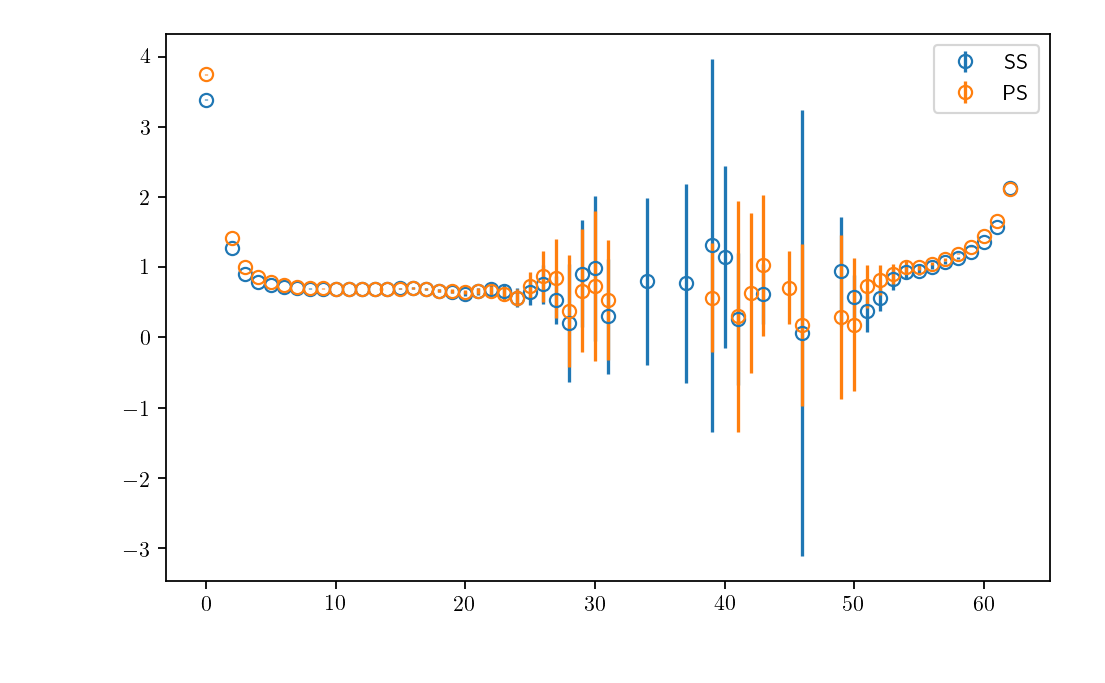

/Users/cchang5/anaconda/envs/pyqcd3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


<IPython.core.display.Javascript object>


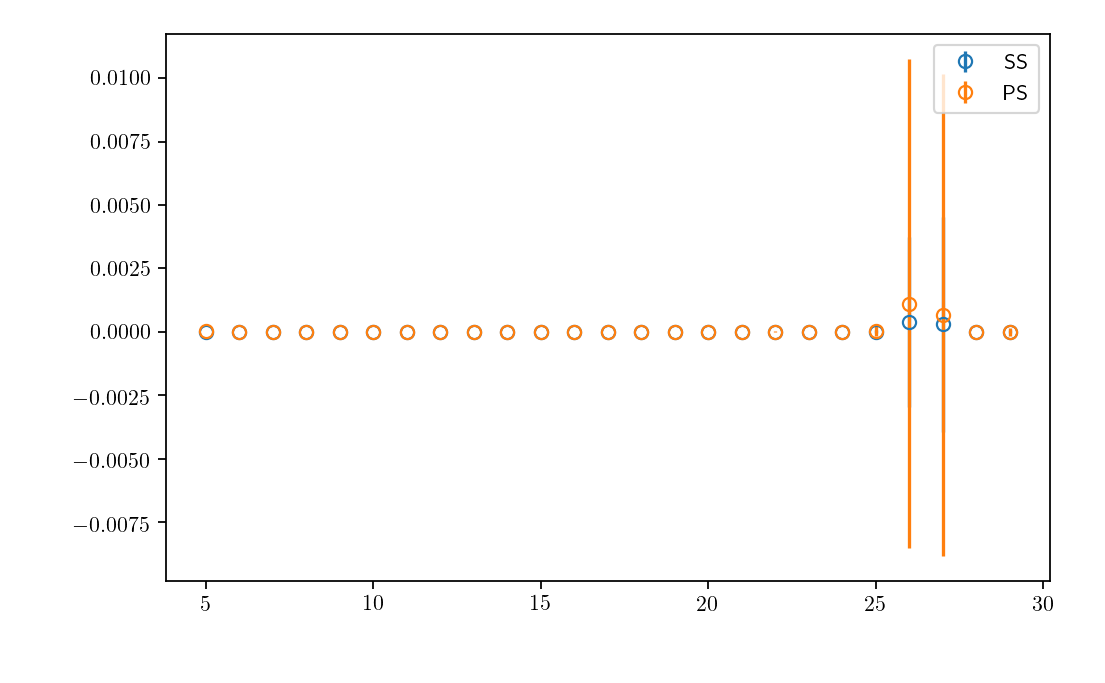

In [4]:
# plot data
fig = plt.figure('effective mass', figsize=(7,4.326237))
ax = plt.axes([0.15,0.15,0.8,0.8])
for k in gvdata.keys():
    meff = np.arccosh((np.roll(gvdata[k],1)+np.roll(gvdata[k],-1))/(2.*gvdata[k]))
    x = np.arange(len(meff))
    #cut = np.arange(5,25)
    cut = np.arange(len(x))
    ax.errorbar(x=x[cut],y=[i.mean for i in meff[cut]], yerr=[i.sdev for i in meff[cut]], ls='None',marker='o',fillstyle='none',label=k)
ax.legend()
fig = plt.figure('scaled correlator', figsize=(7,4.326237))
ax = plt.axes([0.15,0.15,0.8,0.8])
for k in gvdata.keys():
    scorr = gvdata[k]*np.exp(meff*np.arange(len(meff)))
    x = np.arange(len(scorr))
    cut = np.arange(5,30)
    #cut = np.arange(len(x))
    ax.errorbar(x=x[cut],y=[i.mean for i in scorr[cut]], yerr=[i.sdev for i in scorr[cut]], ls='None',marker='o',fillstyle='none',label=k)
ax.legend()
plt.show()

In [5]:
# create priors
prior = dict()
prior['Z0_p'] = gv.gvar(6.1E-3, 6.1E-4)
prior['Z0_s'] = gv.gvar(1.6E-3, 1.6E-4)
prior['E0'] = gv.gvar(0.686,0.0686)

prior['Z1_p'] = gv.gvar(0.0, 6.1E-3)
prior['Z1_s'] = gv.gvar(0.0, 8E-4)
prior['E1'] = gv.gvar(0.0,1.55)

prior['Z2_p'] = gv.gvar(0.0, 6.1E-2)
prior['Z2_s'] = gv.gvar(0.0, 8E-3)
prior['E2'] = gv.gvar(-0.85,0.7)

prior['Z3_p'] = gv.gvar(0.0, 6.1E-3)
prior['Z3_s'] = gv.gvar(0.0, 8E-4)
prior['E3'] = gv.gvar(-0.85,0.7)

p = dict()
for k in prior.keys():
    if int(k[1]) < nstates: p[k] = prior[k]
p

{'E0': 0.686(69),
 'E1': 0.0(1.6),
 'E2': -0.85(70),
 'Z0_p': 0.00610(61),
 'Z0_s': 0.00160(16),
 'Z1_p': 0.0000(61),
 'Z1_s': 0.00000(80),
 'Z2_p': 0.000(61),
 'Z2_s': 0.0000(80)}

In [6]:
result = dict()
Fit = nn.Fit(nstates)
for tmin in range(tmin_list[0],tmin_list[1]+1):
    result[tmin] = dict()
    for tmax in range(tmax_list[0],tmax_list[1]+1):
        x = np.arange(tmin,tmax)
        y = dict()
        for k in data.keys():
            y[k] = gvdata[k][x]
        fit = lsqfit.nonlinear_fit(data=(x,y),prior=p,fcn=Fit.twopt_ssps,maxit=1000000)
        if tmin_list[1]-tmin_list[0]==0 and tmax_list[1]-tmax_list[0]==0: print(fit)
        result[tmin][tmax] = fit

Least Square Fit:
  chi2/dof [dof] = 0.83 [32]    Q = 0.74    logGBF = 780.66

Parameters:
           Z0_p      0.005988 (35)        [ 0.00610 (61) ]  
           Z0_s     0.0015632 (76)        [ 0.00160 (16) ]  
             E0        0.6841 (12)        [   0.686 (69) ]  
           Z1_p    9e-08 +- 0.0061        [  0.0000 (61) ]  
           Z1_s   -1e-08 +- 0.0008        [ 0.00000 (80) ]  
             E1        -0.546 (19)        [    0.0 (1.6) ]  
           Z2_p       0.01297 (23)        [   0.000 (61) ]  
           Z2_s      0.001840 (21)        [  0.0000 (80) ]  
             E2         -0.85 (70)        [   -0.85 (70) ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08*,1e-10,1e-10)    (itns/time = 99/0.1)



<IPython.core.display.Javascript object>


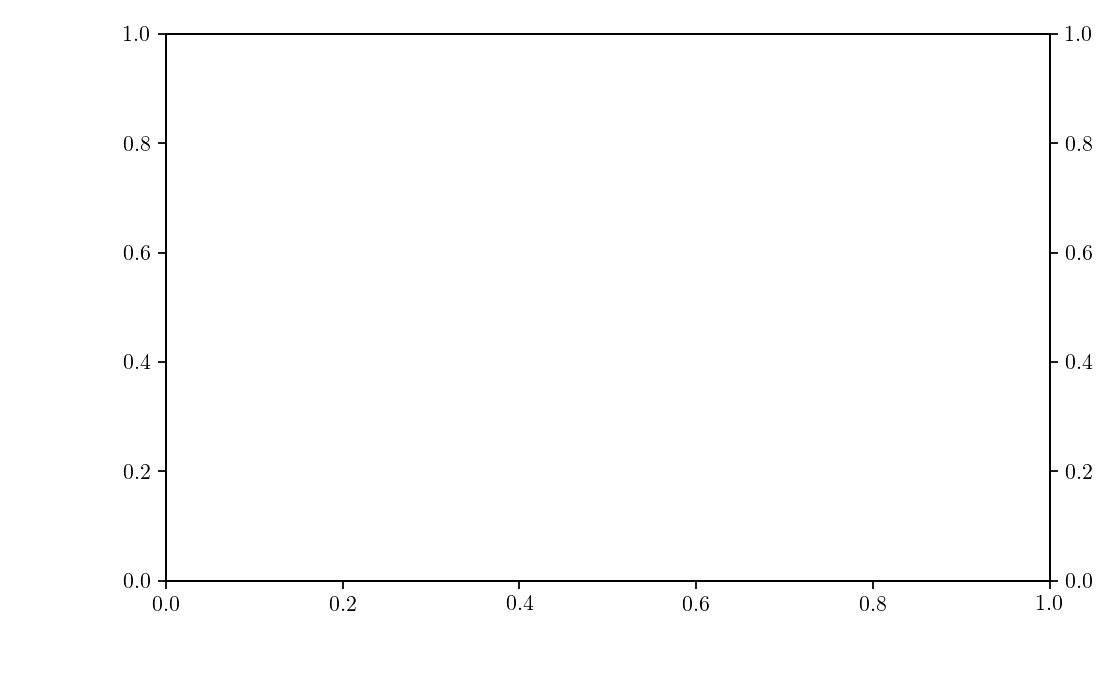

In [7]:
# plot stability
fig = plt.figure('stability', figsize=(7,4.326237))
ax = plt.axes([0.15,0.15,0.8,0.8])
ax1 = ax.twinx()
tmin_length = len(result.keys())
tmax_length = len(result[tmin_list[0]].keys())
for tmin in result.keys():
    for tmax in result[tmin].keys():
        if tmin_length > 1:
            x = tmin
        elif tmax_length > 1:
            x = tmax
        else: break
        y = result[tmin][tmax].p['E0']
        q = result[tmin][tmax].Q
        ax.errorbar(x=x,y=y.mean, yerr=y.sdev, ls='None',marker='o',fillstyle='none',color='black')
        ax1.errorbar(x=x,y=q,ls='None',marker='s',color='red')
plt.show()

In [8]:
for tmin in result.keys():
    for tmax in result[tmin].keys():
        print('E0 :',result[tmin][tmax].p['E0'])
        print('Z0s:',result[tmin][tmax].p['Z0_s'])
        print('Z0p:',result[tmin][tmax].p['Z0_p'])
        print('Z2s/Z2p:',result[tmin][tmax].p['Z2_s']/result[tmin][tmax].p['Z2_p'])

E0 : 0.6841(12)
Z0s: 0.0015632(76)
Z0p: 0.005988(35)
Z2s/Z2p: 0.1419(17)
